In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]#함수의 결과 중에서 디렉터리 목록을 가져오는 부분
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


In [6]:
for n, id in tqdm(enumerate(train_ids), total=len(train_ids)):
    path=TRAIN_PATH + id
    img=imread(path+ '/images/'+id+'.png')[:,:,:IMG_CHANNELS]
    img=resize(img,(128,128),mode='constant', preserve_range=True)
    X_train[n]=img #훈련집합에 이미지 넣기
    mask=np.zeros((128,128,1),dtype=bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_=imread(path+'/masks/'+mask_file)
        mask_=np.expand_dims(resize(mask_,(128,128), mode='constant',preserve_range=True), axis=-1)
        mask=np.maximum(mask,mask_) #여러 마스크 병합
        Y_train[n]=mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:34<00:00,  4.34it/s]


In [7]:
X_test=np.zeros((len(test_ids), 128,128,3), dtype=np.uint8)
sizes_test=[]
for n, id in tqdm(enumerate(test_ids), total=len(test_ids)):
    path=TEST_PATH+id
    img=imread(path+'/images/'+id+'.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0],img.shape[1]])#이미지 높이와 폭. 복원할떄 사용 가능
    img=resize(img,(128,128),mode='constant',preserve_range=True)
    X_test[n]=img

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 87.15it/s]


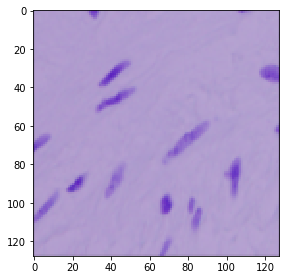

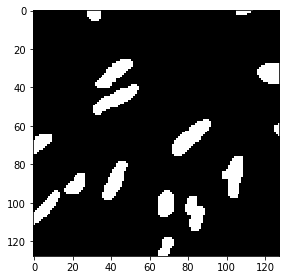

In [8]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix])) #불필요한 차원 제거 2D로 변환
plt.show()

In [9]:
#iou: 정답 영역과 예측영역의 겹쳐진 부분의 비율
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.float32)  # y_pred를 임계값과 비교하여 2진화된 예측값 생성
        y_true = tf.cast(y_true, tf.float32)  # y_true를 tf.float32로 변환
        intersection = tf.reduce_sum(tf.cast(y_true * y_pred_, tf.float32))  # 실제 레이블과 예측값 간의 IoU 계산
        union = tf.reduce_sum(tf.cast(y_true + y_pred_ > 0, tf.float32))
        iou = intersection / union
        prec.append(iou)
    return K.mean(K.stack(prec), axis=0)

In [10]:
#U-Net

inputs= Input((128,128,3))
s=Lambda(lambda x: x/255) (inputs) #정규화

#1번쨰 블록
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

#2
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

#3
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

#4
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#5
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])#u6와 인코더 블록 c4의 출력을 연결
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________

In [11]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


In [12]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])




Train on 603 samples, validate on 67 samples
Epoch 1/50





603/603 [==============================] - 28s 47ms/step - loss: 0.4123 - mean_iou: 0.1552 - val_loss: 0.2141 - val_mean_iou: 0.4240

Epoch 00001: val_loss improved from inf to 0.21414, saving model to model.h5
Epoch 2/50
603/603 [==============================] - 28s 46ms/step - loss: 0.1959 - mean_iou: 0.5534 - val_loss: 0.1889 - val_mean_iou: 0.5097

Epoch 00002: val_loss improved from 0.21414 to 0.18890, saving model to model.h5
Epoch 3/50
603/603 [==============================] - 27s 45ms/step - loss: 0.1594 - mean_iou: 0.6317 - val_loss: 0.2735 - val_mean_iou: 0.5220

Epoch 00003: val_loss did not improve from 0.18890
Epoch 4/50
603/603 [==============================] - 30s 50ms/step - loss: 0.1434 - mean_iou: 0.6628 - val_loss: 0.1164 - val_mean_iou: 0.7077

Epoch 00004: val_loss improved from 0.18890 to 0.11643, saving model to model.h5
Epoch 5/50
603/603 [==============================] - 30s 50ms/step - loss: 0

In [13]:
model = load_model('model.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 0s 6ms/step


In [14]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [20]:
preds_test_upsampled=[]
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]),
                                      mode='constant',preserve_range=True))

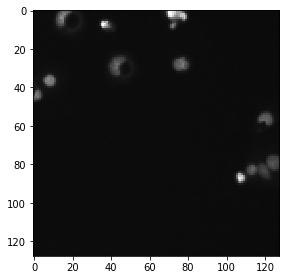

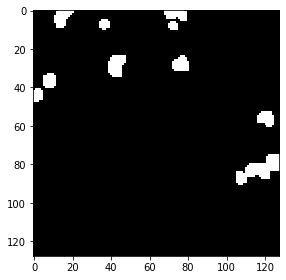

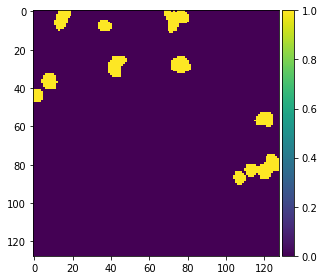

In [36]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

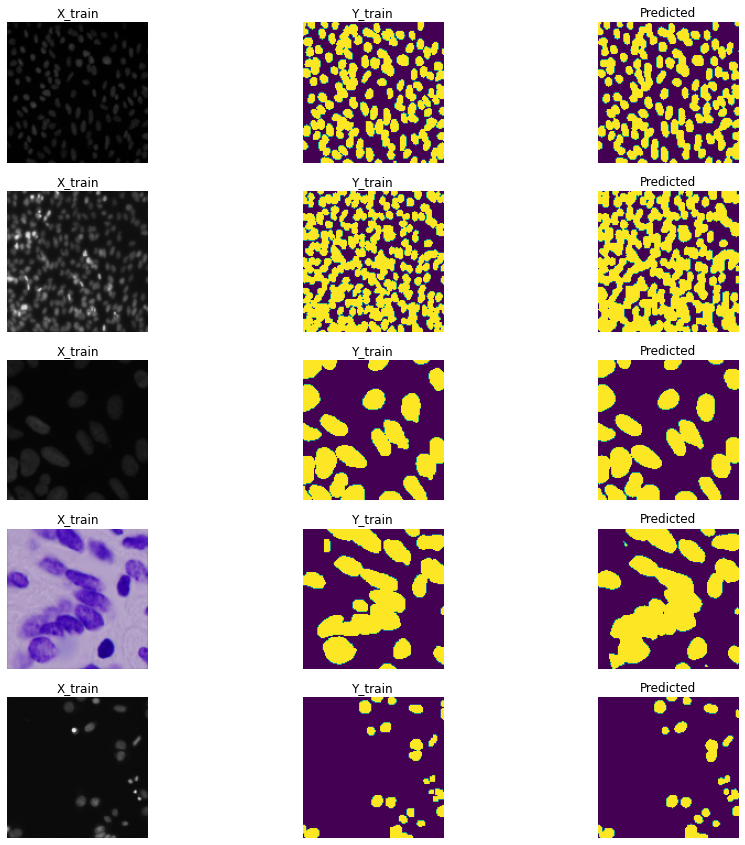

In [37]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

for i in range(5):
    ix = random.randint(0, len(preds_train_t))
    axes[i, 0].imshow(X_train[ix])
    axes[i, 0].set_title('X_train')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(np.squeeze(Y_train[ix]))
    axes[i, 1].set_title('Y_train')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(np.squeeze(preds_train_t[ix]))
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')

plt.show()


In [ ]:
#from: https://www.kaggle.com/code/capecrusader27/unet-augmentation-segmentation-models